In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
trans_data = pd.read_csv(r'data.csv', index_col = 0)

In [2]:
trans_data = trans_data.rename(columns={'Semana':'week', 'Agencia_ID': 'agency', 'Canal_ID':'channel', 'Ruta_SAK':'route',
                  'Cliente_ID':'client', 'Producto_ID':'product', 'Venta_uni_hoy':'sale_units', 'Venta_hoy':'sale_value',
                  'Dev_uni_proxima':'return_units', 'Dev_proxima':'return_value'})

In [3]:
#lets check the data type of the our columns
for column in trans_data.columns:
    print ('{}, {}'.format(column, trans_data[column].dtype))

week, int64
agency, int64
channel, int64
route, int64
client, int64
product, int64
sale_units, int64
sale_value, float64
return_units, int64
return_value, float64


In [4]:
# now we change the data types for columns associated with IDs - week, agency, channel, route, client, product
id_columns = ['week', 'agency', 'channel', 'route', 'client', 'product']
for id_column in id_columns:
    trans_data[id_column] = trans_data[id_column].astype(str)

In [5]:
trans_data.head()

,week,agency,channel,route,client,product,sale_units,sale_value,return_units,return_value
0,3,1111,1,1001,50827,73,6,127.92,0,0.0
1,3,1111,1,1001,50827,693,5,48.00,0,0.0
2,3,1111,1,1001,50827,1109,21,315.21,0,0.0
3,3,1111,1,1001,50827,1125,37,355.20,0,0.0
4,3,1111,1,1001,50827,1129,12,211.20,0,0.0


In [6]:
total_sale_units = sum(trans_data['sale_units'])
total_sale_value = sum(trans_data['sale_value'])
total_return_units = sum(trans_data['return_units'])
total_return_value = sum(trans_data['return_value'])

print('The total units sold are {} of which {} units are returned over the period of 9 weeks'
      .format(total_sale_units, total_return_units))
print('Total value of retured products is {} which is {}% of total revenue'
      .format(total_return_value, (total_return_value * 100 / total_sale_value)))

The total units sold are 35580732 of which 1467288 units are returned over the period of 9 weeks
Total value of retured products is 11429498.290000629 which is 2.9109851555489223% of total revenue


In [7]:
route_wise_summary = trans_data.groupby(['route']).sum().reset_index()
route_wise_summary.head()

,route,sale_units,sale_value,return_units,return_value
0,1,292239,4877877.43,2076,30737.60
1,10,60591,966843.75,13,272.61
2,100,43408,772131.36,0,0.00
3,1001,82814,1346459.31,126,2053.59
4,1002,32040,486980.46,96,1344.35


No handles with labels found to put in legend.


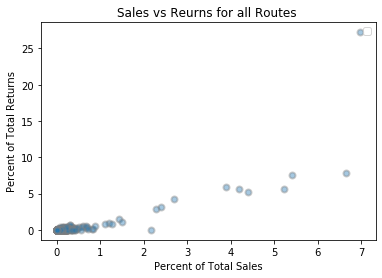

In [8]:
x = [i*100/sum(route_wise_summary['sale_units']) for i in route_wise_summary['sale_units']]  # normalising sales
y = [i*100/sum(route_wise_summary['return_units']) for i in route_wise_summary['return_units']] # normalising returns
# z = route_wise_summary['agency_count'] # list of count of agencies using routes
 
# plt.scatter(x, y, s=z*50, alpha=0.4, edgecolors="grey", linewidth=2)
plt.scatter(x, y, alpha=0.4, edgecolors="grey", linewidth=2)
 
plt.xlabel("Percent of Total Sales")
plt.ylabel("Percent of Total Returns")
plt.title("Sales vs Reurns for all Routes ")
plt.legend()
plt.show()

In [9]:
# we can clearly see that our top 10 revenue genrating routes also tend to contribute to most of our returns
# we can also see one route that one route is contributing more that 25% of total returns
# we now try to look into the data for any abmnormalities if present
# for this, we can first sort the route_wise_summary dataframe and see the top returning routes
# and then use our original transaction data to check for any abnormal transactions for those routes
top_10_routes = route_wise_summary.sort_values(by=['return_units'], ascending = False).head(10)
returns = sum(top_10_routes['return_units'])/sum(route_wise_summary['return_units']) * 100
route_list = list(top_10_routes['route'])
print( 'routes - {} contribute to a total of {}% of total returns'.format(route_list, returns))

routes - ['3001', '3002', '3003', '3007', '3004', '3005', '3006', '3008', '3010', '3009'] contribute to a total of 75.10556891353299% of total returns


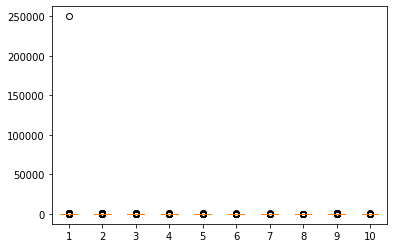

In [10]:
# Now we try to analyse the transactions for these routes one by one to check for abnormalities

bxplots = []
for route in route_list:
    bxplots.append(list(trans_data.loc[trans_data['route'] == route]['return_units']))
    
plt.boxplot(bxplots)
plt.show()

In [11]:
# we can see that there is certainly an outlier for route 3001 which is leading to large number of returns
# to find this outier, we filter and sort the data for route 3001 to find any agency or client contributing to this return
data_3001 = trans_data.loc[trans_data['route'] == '3001']
data_3001.sort_values(by=['return_units'], ascending = False).head()

,week,agency,channel,route,client,product,sale_units,sale_value,return_units,return_value
427689,9,1255,5,3001,653378,3509,0,0.00,250000,2500.00
112153,4,1974,5,3001,653378,43230,3170,23489.70,845,6261.45
112150,4,1974,5,3001,653378,43070,1367,8858.16,807,5229.36
309395,7,1915,5,3001,652850,34389,0,0.00,766,7093.16
47692,3,1991,5,3001,653378,30008,1068,9889.68,608,5630.08


In [12]:
# The top transaction for lient 653378 in week 9 shows 250000 units returned with a value 2500 which is wierd
# We now try to narrow down to the client's weekly transactions to know more about this return entry
temp_df = trans_data.loc[trans_data['client'] == '653378']
weekly_trans = pd.pivot_table(temp_df, values=['sale_units', 'return_units'], index='product',
                              columns = 'week', aggfunc='sum')
weekly_trans.columns =[s1 + str(s2) for (s1,s2) in weekly_trans.columns.tolist()]
weekly_trans.reset_index(inplace=True)
weekly_trans.head()

,product,return_units3,return_units4,return_units5,return_units6,return_units7,return_units8,return_units9,sale_units3,sale_units4,sale_units5,sale_units6,sale_units7,sale_units8,sale_units9
0,1216,154.0,80.0,63.0,146.0,169.0,177.0,135.0,462.0,560.0,588.0,573.0,534.0,564.0,518.0
1,1220,346.0,636.0,216.0,394.0,379.0,474.0,549.0,7346.0,7524.0,8440.0,7572.0,8453.0,8082.0,6325.0
2,1240,4746.0,5876.0,6191.0,7608.0,7014.0,7234.0,5900.0,75032.0,73035.0,71170.0,62682.0,66684.0,61267.0,58966.0
3,1242,475.0,322.0,264.0,362.0,277.0,372.0,268.0,3579.0,3774.0,3710.0,2964.0,2401.0,1907.0,1765.0
4,1250,5364.0,5304.0,4773.0,5296.0,5432.0,5250.0,5313.0,97901.0,104321.0,106826.0,95712.0,101320.0,98093.0,94288.0


In [13]:
weekly_trans.sort_values(by = ['return_units9'], ascending = False).head()

,product,return_units3,return_units4,return_units5,return_units6,return_units7,return_units8,return_units9,sale_units3,sale_units4,sale_units5,sale_units6,sale_units7,sale_units8,sale_units9
92,3509,NaN,NaN,NaN,NaN,NaN,NaN,250000.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,1240,4746.0,5876.0,6191.0,7608.0,7014.0,7234.0,5900.0,75032.0,73035.0,71170.0,62682.0,66684.0,61267.0,58966.0
4,1250,5364.0,5304.0,4773.0,5296.0,5432.0,5250.0,5313.0,97901.0,104321.0,106826.0,95712.0,101320.0,98093.0,94288.0
9,2261,1111.0,777.0,436.0,715.0,2831.0,3433.0,4550.0,21911.0,23782.0,25828.0,26386.0,30831.0,29648.0,26961.0
163,45449,3258.0,3879.0,3020.0,4016.0,3576.0,4067.0,3863.0,51208.0,51249.0,50805.0,47000.0,49324.0,49142.0,51226.0


In [14]:
weekly_trans.loc[92]

product            3509
return_units3       NaN
return_units4       NaN
return_units5       NaN
return_units6       NaN
return_units7       NaN
return_units8       NaN
return_units9    250000
sale_units3         NaN
sale_units4         NaN
sale_units5         NaN
sale_units6         NaN
sale_units7         NaN
sale_units8         NaN
sale_units9           0
Name: 92, dtype: object

In [15]:
# we can see there are no sale transactons for product 3509 for cient 653378 for the given data for weeks 3 - 9
# Hence we assume that this is a wrong data entry and we can exclude it from oour data for further analysis
# we can subtract 250000 from return_units for route 3001 in our route_data_summary and visualize again
route_wise_summary.loc[route_wise_summary['route'] == '3001']

,route,sale_units,sale_value,return_units,return_value
465,3001,2481363,20542634.58,399329,1245663.11


In [16]:
current_value = route_wise_summary.at[465,'return_units']
route_wise_summary.at[465,'return_units'] = current_value - 250000

No handles with labels found to put in legend.


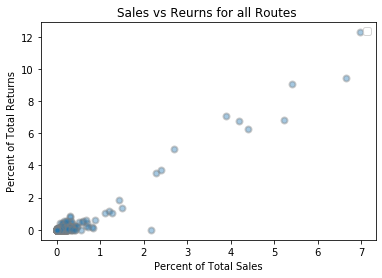

In [17]:
x = [i*100/sum(route_wise_summary['sale_units']) for i in route_wise_summary['sale_units']]  # normalising sales
y = [i*100/sum(route_wise_summary['return_units']) for i in route_wise_summary['return_units']] # normalising returns
# z = route_wise_summary['agency_count'] # list of count of agencies using routes
 
# plt.scatter(x, y, s=z*50, alpha=0.4, edgecolors="grey", linewidth=2)
plt.scatter(x, y, alpha=0.4, edgecolors="grey", linewidth=2)
 
plt.xlabel("Percent of Total Sales")
plt.ylabel("Percent of Total Returns")
plt.title("Sales vs Reurns for all Routes ")
plt.legend()
plt.show()

In [18]:
# We also drop this entry from our original transaction data
trans_data.sort_values(by=['return_units'], ascending = False).head()

,week,agency,channel,route,client,product,sale_units,sale_value,return_units,return_value
427689,9,1255,5,3001,653378,3509,0,0.00,250000,2500.00
162769,5,1250,5,3007,653378,45296,161,1610.00,1740,17400.00
112096,4,1915,5,3010,652850,34389,25,231.50,1588,14704.88
309728,7,1915,5,3010,652850,34389,576,5333.76,1478,13686.28
378999,8,1997,5,3048,653378,7814,110,916.30,1389,11570.37


In [19]:
trans_data = trans_data.drop([427689])

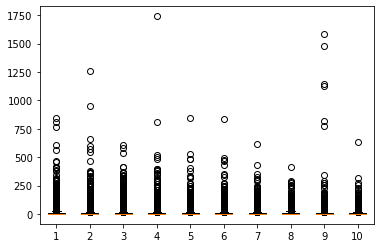

In [20]:
# Now we can check the box plots again for route wise return transactions 
bxplots = []
for route in route_list:
    bxplots.append(list(trans_data.loc[trans_data['route'] == route]['return_units']))
    
plt.boxplot(bxplots)
plt.show()

In [21]:
# the max returns for any transaction is somewhere around 1750 units which is reasonable
# so we can assume there are no more abnrmal entries for transactions
# Now we can check how much contribution to the total returns is done by these top 10 routes
top_10_routes = route_wise_summary.sort_values(by=['return_units'], ascending = False).head(10)
returns = sum(top_10_routes['return_units'])/sum(route_wise_summary['return_units']) * 100
route_list = list(top_10_routes['route'])
print( 'routes - {} contribute to a total of {}% of total returns'.format(route_list, returns))

routes - ['3001', '3002', '3003', '3007', '3004', '3005', '3006', '3008', '3010', '3009'] contribute to a total of 69.99288582488286% of total returns


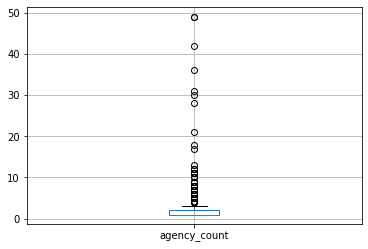

In [22]:
# Even after removing the outlier, we still have these top 10 routes contributing to 70% of the returns
# We can see that these routes are shared between agencies
# Hence try to analyse the utility of these routes by agencies

route_to_agencies = trans_data[['route','agency']].drop_duplicates()
route_usage = dict(route_to_agencies['route'].value_counts())
route_to_agencies = pd.DataFrame(([k, v] for k, v in route_usage.items()), columns=['route', 'agency_count'])
route_to_agencies.boxplot(['agency_count'])

In [23]:
route_wise_summary = pd.merge(route_wise_summary, route_to_agencies, on='route')  # joining the dataframe objects
route_wise_summary.head()

,route,sale_units,sale_value,return_units,return_value,agency_count
0,1,292239,4877877.43,2076,30737.60,4
1,10,60591,966843.75,13,272.61,1
2,100,43408,772131.36,0,0.00,1
3,1001,82814,1346459.31,126,2053.59,13
4,1002,32040,486980.46,96,1344.35,6


No handles with labels found to put in legend.


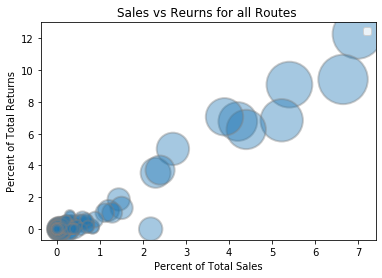

In [24]:
x = [i*100/sum(route_wise_summary['sale_units']) for i in route_wise_summary['sale_units']]  # normalising sales
y = [i*100/sum(route_wise_summary['return_units']) for i in route_wise_summary['return_units']] # normalising returns
z = route_wise_summary['agency_count'] # list of count of agencies using routes
 
plt.scatter(x, y, s=z*50, alpha=0.4, edgecolors="grey", linewidth=2)
 
plt.xlabel("Percent of Total Sales")
plt.ylabel("Percent of Total Returns")
plt.title("Sales vs Reurns for all Routes ")
plt.legend()
plt.show()